Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

> Loads the raw training and test CSV files, computes the `ClaimRate` target, removes unused identifier and exposure columns, and splits the data into feature matrices (`X_train`, `X_test`) and target vectors (`y_train`, `y_test`).


In [ ]:
train_df = pd.read_csv("../data/raw/claims_raw_train.csv")
test_df  = pd.read_csv("../data/raw/claims_raw_test.csv")

# Create target
train_df["ClaimRate"] = train_df["ClaimNb"] / train_df["Exposure"]
test_df["ClaimRate"]  = test_df["ClaimNb"] / test_df["Exposure"]

# Drop unused columns
train_df.drop(["IDpol", "ClaimNb", "Exposure"], axis=1, inplace=True)
test_df.drop(["IDpol", "ClaimNb", "Exposure"], axis=1, inplace=True)

target = "ClaimRate"

# y = target, X = features
y_train = train_df[target].to_numpy()
y_test  = test_df[target].to_numpy()

X_train = train_df.drop(columns=[target])
X_test  = test_df.drop(columns=[target])

> Preprocesses the training and test feature dataframes by:
> - Splitting columns into numeric, ordinal, and nominal (one-hot) groups.  
> - Treating `VehPower` and `Area` as ordinal features with explicitly defined value orderings.  
> - Applying a numeric pipeline (median imputation + standard scaling), an ordinal pipeline (most-frequent imputation + `OrdinalEncoder`), and a one-hot pipeline (most-frequent imputation + dense `OneHotEncoder`).  
> - Fitting a `ColumnTransformer` on `X_train` and transforming both `X_train` and `X_test`.  
> - Printing basic diagnostics (shapes, sparsity, and column counts) and returning the transformed arrays, the fitted preprocessor, and a dictionary describing which columns went into each block.

In [4]:
def preprocess(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    cat_all = X_train.select_dtypes(include=["object","category","string","bool"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_all]

    ord_cols = []
    ord_categories = []

    num_cols.remove("VehPower")
    unique_vals = pd.Series(X_train["VehPower"]).dropna().unique()
    unique_vals_num = pd.to_numeric(unique_vals, errors="raise")
    vehpower_order = sorted(unique_vals_num.tolist())
    ord_cols.append("VehPower")
    ord_categories.append(vehpower_order)

    area_order = sorted(pd.Series(X_train["Area"]).dropna().astype(str).unique().tolist())
    ord_cols.append("Area")
    ord_categories.append(area_order)
    if "Area" in cat_all:
        cat_all.remove("Area")

    ohe_cols = [c for c in cat_all if c not in ord_cols]

    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler(with_mean=True, with_std=True)),
    ])

    ord_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ord", OrdinalEncoder(
            categories=ord_categories,
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )),
    ]) if ord_cols else "drop"

    ohe_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)),
    ]) if ohe_cols else "drop"

    transformers = []
    transformers.append(("num", num_pipe, num_cols))
    transformers.append(("ord", ord_pipe, ord_cols))
    transformers.append(("ohe", ohe_pipe, ohe_cols))

    pre = ColumnTransformer(transformers=transformers, remainder="drop")

    X_train = pre.fit_transform(X_train)
    X_test  = pre.transform(X_test)

    print(f"Train: {X_train.shape} | {'sparse' if sparse.isspmatrix(X_train) else 'dense'}")
    print(f"Test : {X_test.shape}  | {'sparse' if sparse.isspmatrix(X_test) else 'dense'}")
    print("Numeric:", len(num_cols), "| Ordinal:", len(ord_cols), "| OHE:", len(ohe_cols))
    if "VehPower" in ord_cols:
        print("VehPower order:", ord_categories[ord_cols.index("VehPower")])
    if "Area" in ord_cols:
        print("Area order:", ord_categories[ord_cols.index("Area")])

    return X_train, X_test, pre, {"num": num_cols, "ord": ord_cols, "ohe": ohe_cols}

> Fits a PCA model on the training feature matrix to analyze how many principal components are needed to reach a desired variance threshold. It:
> - Runs PCA with up to `n_features - 1` components (optionally using randomized SVD).  
> - Computes the explained variance ratio and its cumulative sum.  
> - Plots the cumulative explained variance against the number of components (the “PCA elbow” plot).  
> - Returns the fitted PCA object, the per-component explained variance ratios, the cumulative curve, and the smallest number of components needed to reach the target cumulative variance (`target`).

In [5]:
def elbow_on_train(X_train: int, randomized: bool, seed: int, target: float):
    reducer = PCA(
        n_components=X_train.shape[1]-1,
        svd_solver="randomized",
        iterated_power=7 if randomized else "auto",
        random_state=seed
    )
    
    reducer.fit(X_train)
    evr = reducer.explained_variance_ratio_
    cum = np.cumsum(evr)
    
    plt.figure()
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.xlabel("k components")
    plt.ylabel("Cumulative explained variance")
    plt.title(("PCA") + " Elbow (train only)")
    plt.grid(True)
    plt.show()

    return reducer, evr, cum, int(np.searchsorted(cum, target) + 1)

> Runs the full preprocessing and PCA dimensionality-reduction pipeline:
> - Applies the `preprocess` function to obtain transformed feature matrices for train and test, along with the fitted preprocessor and column info.  
> - Calls `elbow_on_train` to determine how many principal components (`k`) are needed to retain at least 90% of the variance.  
> - Fits a final PCA model with `k` components on `X_train` and transforms both `X_train` and `X_test` into reduced representations `Z_train` and `Z_test`.  
> - Prints the shapes of the reduced matrices and the total fraction of variance preserved by the selected components.

Train: (542410, 42) | dense
Test : (135603, 42)  | dense
Numeric: 5 | Ordinal: 2 | OHE: 3
VehPower order: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Area order: ['A', 'B', 'C', 'D', 'E', 'F']


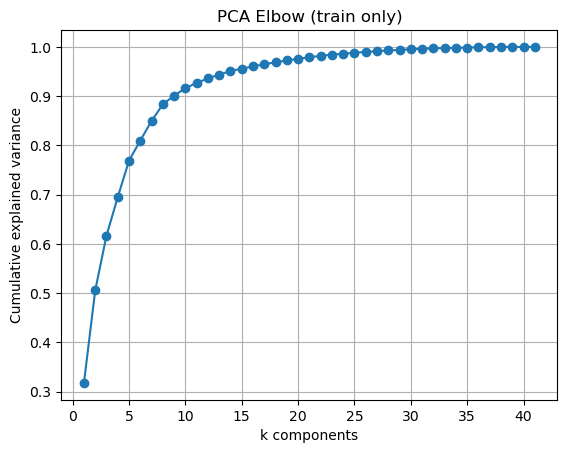

Z_train shape: (542410, 9) Z_test shape: (135603, 9)
Cumulative variance kept: 0.9011289525885328


In [6]:
X_train, X_test, pre, col = preprocess(train_df, test_df)
probe, evr, cum, k = elbow_on_train(X_train, True, 42, 0.9)
reducer = PCA(n_components=k, svd_solver="randomized", iterated_power=7, random_state=42)
reducer.fit(X_train)

Z_train = reducer.transform(X_train)
Z_test = reducer.transform(X_test)

evr_final = reducer.explained_variance_ratio_

evr_final = reducer.explained_variance_ratio_
print("Z_train shape:", Z_train.shape, "Z_test shape:", Z_test.shape)
print("Cumulative variance kept:", float(np.cumsum(evr_final)[-1]))

> Defines a helper function to visualize the PCA-reduced data in 2D using the first two principal components.  
> - `plot_2d_from_pca` scatters `Z[:, 0]` vs. `Z[:, 1]`, coloring points by the provided target or label array `y`, and adds a colorbar and basic axes labels/grid.  
> - The example call plots the training data `Z_train` in the space of the first two principal components, using the original target values (`y_train`) as colors and annotating the title with the number of PCA dimensions (`k`) used before projecting to 2D.

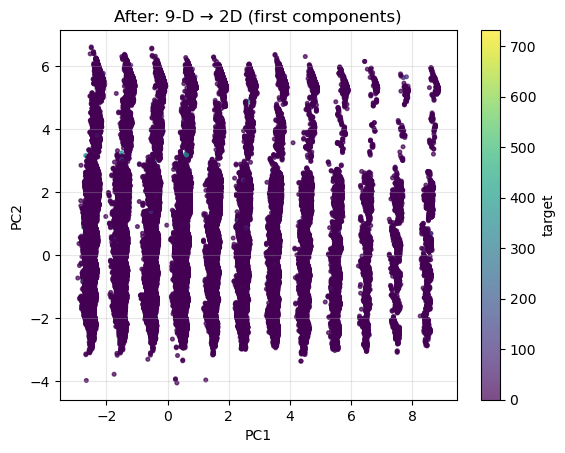

In [7]:
def plot_2d_from_pca(Z, y, title="After PCA (first 2 comps)"):
    plt.figure()
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, s=7, alpha=0.7)
    plt.colorbar(sc, label="target")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.show()

y_log = np.log1p(y_train)
plot_2d_from_pca(Z_train, y_train, title=f"After: {k}-D → 2D (first components)")

Clustering

> Estimates a suitable number of clusters for KMeans by scanning over different `k` values on a (possibly) subsampled PCA space:
> - Optionally subsamples the training representation `Z_train` to at most `max_samples` points for computational efficiency.  
> - For each `k` in `[k_min, k_max]`, fits a KMeans model, records its inertia (within-cluster sum of squares), and computes the silhouette score on the subsample.  
> - Plots both the inertia curve (for the elbow method) and the silhouette curve side by side to help choose an appropriate number of clusters.

In [ ]:
def find_best_k(Z_train, k_min=2, k_max=15, random_state=42, max_samples=20000):
    rng = np.random.default_rng(random_state)
    if Z_train.shape[0] > max_samples:
        idx = rng.choice(Z_train.shape[0], size=max_samples, replace=False)
        Z_sub = Z_train[idx]
    else:
        Z_sub = Z_train

    inertias = []
    silhouettes = []

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels_sub = km.fit_predict(Z_sub)

        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(Z_sub, labels_sub))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(k_min, k_max+1), inertias, marker='o')
    plt.title("KMeans inertia (elbow)")
    plt.xlabel("k"); plt.ylabel("Inertia")

    plt.subplot(1,2,2)
    plt.plot(range(k_min, k_max+1), silhouettes, marker='o')
    plt.title("Silhouette score (subsample)")
    plt.xlabel("k"); plt.ylabel("Silhouette")

    plt.tight_layout()
    plt.show()

    return inertias, silhouettes

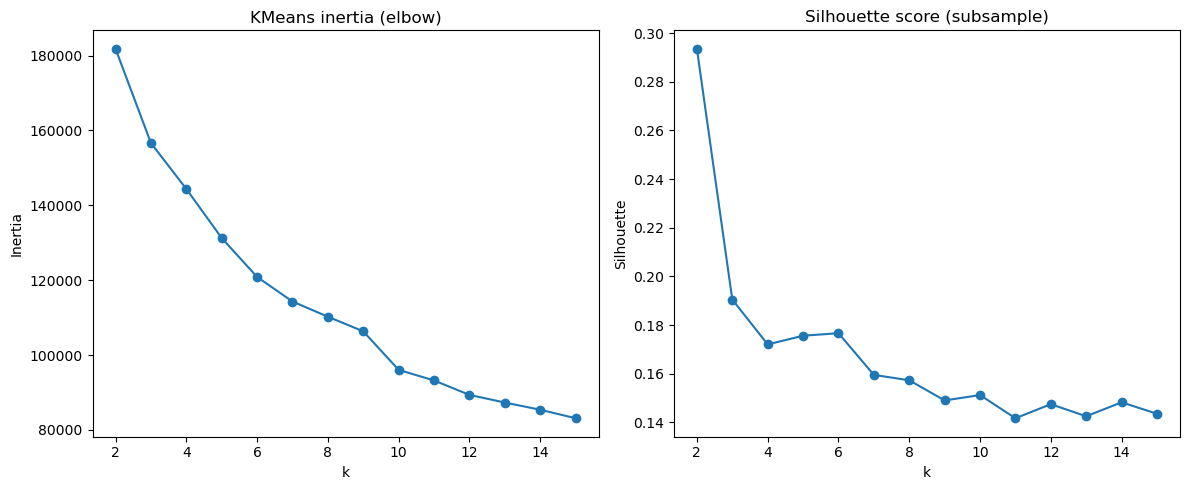

In [30]:
inertias, silhouettes = find_best_k(Z_train)

> Chooses a fixed number of clusters (`k_best = 5`) for KMeans based on prior inspection of the inertia and silhouette curves, then:
> - Fits a KMeans model with 5 clusters on the full PCA-reduced training data `Z_train`.  
> - Uses the fitted model to assign cluster labels to both the training set (`cluster_train`) and the PCA-transformed test set (`cluster_test`), producing a consistent cluster-based feature for downstream modeling.

In [26]:
# k_best = np.argmax(silhouettes) + 2
k_best = 5
kmeans = KMeans(n_clusters=k_best, n_init="auto", random_state=42)
cluster_train = kmeans.fit_predict(Z_train)
cluster_test  = kmeans.predict(Z_test)

> Saves the clusters as features for later use

In [27]:
train_with_clusters = train_df.copy()
test_with_clusters  = test_df.copy()

train_with_clusters["Cluster"] = cluster_train
test_with_clusters["Cluster"]  = cluster_test

> Visualizes the KMeans clusters (computed earlier on the full PCA-reduced space `Z_train` with all retained components) in two dimensions:
> - Fits a separate 2D PCA (`viz_pca`) on `Z_train` and projects it to `proj_2d` purely for plotting.  
> - Uses the precomputed cluster labels `cluster_train` (from KMeans run on the full-dimensional `Z_train`) to color the points in this 2D projection.  
> - Produces a scatter plot where each point’s position comes from the 2D PCA projection, and its color indicates its cluster assignment from the high-dimensional KMeans model, giving an interpretable view of how the full-space clusters look when compressed to two dimensions.

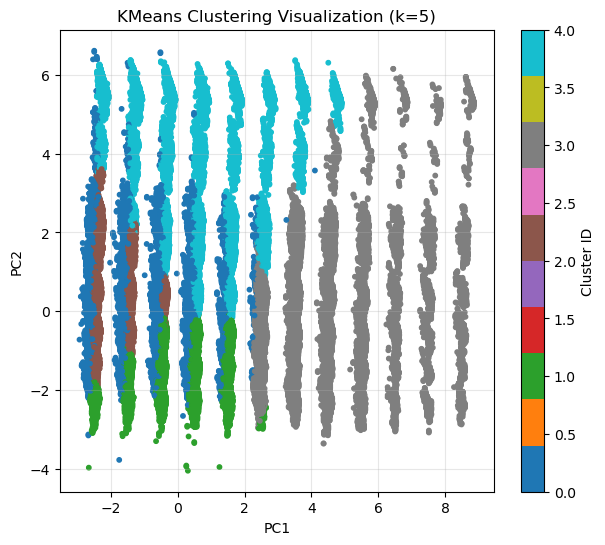

In [28]:
viz_pca = PCA(n_components=2, random_state=42)
proj_2d = viz_pca.fit_transform(Z_train)

plt.figure(figsize=(7,6))
sc = plt.scatter(proj_2d[:,0], proj_2d[:,1], c=cluster_train, cmap="tab10", s=10)
plt.title(f"KMeans Clustering Visualization (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.colorbar(sc, label="Cluster ID")
plt.show()


> Performs KMeans clustering directly in a 2D PCA projection for an intuitive, visually aligned cluster plot:  
> - Applies a separate 2D PCA (`viz_pca`) to the high-dimensional PCA-reduced data `Z_train` to obtain `Z2`, a two-dimensional representation used **both** for clustering and plotting.  
> - Fits a KMeans model with `k` clusters on `Z2` and obtains cluster labels (`labels`) in this exact 2D space.  
> - Creates a scatter plot of the 2D PCA coordinates colored by these KMeans labels, showing cluster assignments that correspond directly to the visible point cloud.

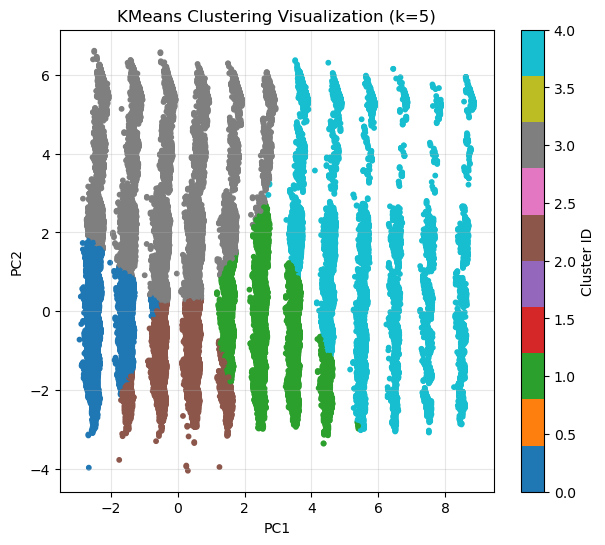

In [29]:
viz_pca = PCA(n_components=2, random_state=42)
Z2 = viz_pca.fit_transform(Z_train)

plt.figure(figsize=(7,6))
labels = KMeans(n_clusters=k_best, n_init="auto", random_state=42).fit_predict(Z2)
sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, cmap="tab10", s=10)
plt.title(f"KMeans Clustering Visualization (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.colorbar(sc, label="Cluster ID")
plt.show();
